# GPU implementation of Bfastmonitor using Python
The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially. 

* Import packages

* Select data

* Set parameters

* Select monitoring period*

* Run bfastmonitor*

* Optional: Load output*

* Merge and save tiles output

* Display output

*After saving the output, one may load it in again instead of running bfastmonitor again


### Import packages

In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, save_plot, normalize, merge_plots 

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [2]:
%matplotlib inline

### Select data

#### Select a name for your output folder. All the segments you run through will be saved here: "./stored_time_series/[yourfoldername]



In [3]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [4]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Output directory name: stored_time_series/Guyana


#### Select a time series segment folder using ipyfilechooser.  The standard download location is in downloads/time_series_name/[0,1,2..n]


In [5]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [6]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    output_dir = set_output_dir(output_directory_chooser,timeseries_directory)
    print(output_dir)

/home/dven/downloads/Time_series_2020-09-01_16-22-26/1/
stored_time_series/Guyana/Guyana_1


#### Load in data: if there are tiles in the directory, create a list and load per tile. The Timeseries tiles and their associated data are put in the list: 'data_list'


In [7]:
# set path to dates file
data_list = set_paths(timeseries_directory = timeseries_directory)
for tile in data_list:
    print(tile)

Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 574 dates, sized 2048 by 2048.
Timeseries class holding 574 dates, sized 1858 by 2048.
Timeseries class holding 574 dates, sized 2048 by 2048.
Timeseries class holding 574 dates, sized 1858 by 2048.
Timeseries class holding 574 dates, sized 2048 by 2048.
Timeseries class holding 574 dates, sized 1858 by 2048.
Timeseries class holding 574 dates, sized 2048 by 1281.
Timeseries class holding 574 dates, sized 1858 by 1281.


### Check some metadata of the created Timeseries class

In [8]:
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
print("n dates in timeseries: ", data_list[0].nbands)

# Uncomment to see al vars associated with the tile
#vars(data_list[0])

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358578
n dates in timeseries:  574


# Set parameters

In [9]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=True, description='add trend', layout=Layout(height='auto', width='500px'…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [10]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

# Select monitoring period

In [11]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 3144), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2012-01-05', Timestamp('…

In [12]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

start_monitor = datetime(2018, 9, 14)



## Loop over tiles, (or single tile), in data_list
### Alternatively, if your means and breaks arrays already exist, skip this code and run load from file in the next block
### If you get a memory error, change the x_block and y_block size to a smaller power of 2: 1080, 512, 256, 128

In [28]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [29]:
x_block = y_block = block_size_chooser.result

# loading bar
with tqdm(total=len(data_list)) as pbar1:
    
    # loop over tile(s) in the data_list
    for counter, tile in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )

        tile.set_bfast_parameters(start_monitor = start_monitor, 
                                     end_monitor = end_monitor,
                                     start_hist = start_hist,
                                     freq = freq,
                                     k = k,
                                     hfrac = hfrac,
                                     trend = trend,
                                     level = level,
                                     backend=backend,
                                     verbose=verbose,
                                     device_id=device_id)
        
        tile.get_bfast_parameters()
        
        tile.loop_blocks(x_block_size = x_block,
                            y_block_size=y_block)
        
        tile.log_all_output(output_dir_name=output_dir)
        
        pbar1.update(counter)
        
pbar1.close()

# Store the cropped dates for optional loading later
with open(output_dir + "/cropped_dates.csv","w") as f:
    for date in data_list[0].cropped_dates:
        f.write(date.strftime("%m/%d/%Y"))
        f.write("\n")

# # temporary solution
# with open(output_dir + "/hist_dates.csv","w") as f:
#     for date in data_list[0].dates:
#         f.write(date.strftime("%m/%d/%Y"))
#         f.write("\n")

Processing tile 1 out of 12:   0%|          | 0/12 [00:00<?, ?it/s]
  0%|          | 0/16.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/16.0 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3b8f870>]
Monitoring starts at:  2018-09-14 00:00:00
Monitoring ends at:  2020-08-19 00:00:00
Dataset history starts at:  2016-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2018-09-14 00:00:00
end monitor:  2020-08-19 00:00:00
start history:  2016-01-05 00:00:00
0 0 512 512
--- runtime for data initializa

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  12%|█▎        | 2/16.0 [00:09<01:09,  4.98s/it]

--- runtime for kernel execution:		0.41129112243652344
--- runtime for data transfer (device->host):	0.013386011123657227
512 0 512 512
--- runtime for data initialization:		0.0017828941345214844
--- runtime for data transfer (host->device):	0.06240677833557129
--- runtime for data preprocessing:		0.011004924774169922


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  19%|█▉        | 3/16.0 [00:16<01:11,  5.53s/it]

--- runtime for kernel execution:		0.1313011646270752
--- runtime for data transfer (device->host):	0.014751911163330078
1024 0 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  25%|██▌       | 4/16.0 [00:23<01:09,  5.83s/it]

--- runtime for data initialization:		0.0017781257629394531
--- runtime for data transfer (host->device):	0.062333106994628906
--- runtime for data preprocessing:		0.009760618209838867
--- runtime for kernel execution:		0.10669422149658203
--- runtime for data transfer (device->host):	0.013458013534545898
1536 0 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  31%|███▏      | 5/16.0 [00:30<01:07,  6.16s/it]

--- runtime for data initialization:		0.0017888545989990234
--- runtime for data transfer (host->device):	0.06254959106445312
--- runtime for data preprocessing:		0.009574651718139648
--- runtime for kernel execution:		0.09304666519165039
--- runtime for data transfer (device->host):	0.008921146392822266
0 512 512 512
--- runtime for data initialization:		0.0017750263214111328
--- runtime for data transfer (host->device):	0.06241416931152344
--- runtime for data preprocessing:		0.010880231857299805
--- runtime for kernel execution:		0.11744213104248047
--- runtime for data transfer (device->host):	0.00986170768737793


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  38%|███▊      | 6/16.0 [00:37<01:04,  6.42s/it]

512 512 512 512
--- runtime for data initialization:		0.001771688461303711
--- runtime for data transfer (host->device):	0.06236386299133301
--- runtime for data preprocessing:		0.012026786804199219


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  44%|████▍     | 7/16.0 [00:44<00:59,  6.59s/it]

--- runtime for kernel execution:		0.13061237335205078
--- runtime for data transfer (device->host):	0.00827789306640625
1024 512 512 512
--- runtime for data initialization:		0.0017583370208740234
--- runtime for data transfer (host->device):	0.06233716011047363
--- runtime for data preprocessing:		0.010782480239868164


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  50%|█████     | 8/16.0 [00:51<00:53,  6.71s/it]

--- runtime for kernel execution:		0.12876224517822266
--- runtime for data transfer (device->host):	0.01713705062866211
1536 512 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  56%|█████▋    | 9/16.0 [00:58<00:47,  6.84s/it]

--- runtime for data initialization:		0.0017571449279785156
--- runtime for data transfer (host->device):	0.06243252754211426
--- runtime for data preprocessing:		0.009697437286376953
--- runtime for kernel execution:		0.10442304611206055
--- runtime for data transfer (device->host):	0.013062715530395508
0 1024 512 512
--- runtime for data initialization:		0.001786947250366211
--- runtime for data transfer (host->device):	0.06240129470825195
--- runtime for data preprocessing:		0.010865449905395508


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  62%|██████▎   | 10/16.0 [01:05<00:41,  6.87s/it]

--- runtime for kernel execution:		0.1296398639678955
--- runtime for data transfer (device->host):	0.00840902328491211
512 1024 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  69%|██████▉   | 11/16.0 [01:12<00:34,  6.92s/it]

--- runtime for data initialization:		0.001794576644897461
--- runtime for data transfer (host->device):	0.06256365776062012
--- runtime for data preprocessing:		0.009894132614135742
--- runtime for kernel execution:		0.10789752006530762
--- runtime for data transfer (device->host):	0.007838964462280273
1024 1024 512 512
--- runtime for data initialization:		0.0017659664154052734
--- runtime for data transfer (host->device):	0.06263518333435059
--- runtime for data preprocessing:		0.010519742965698242
--- runtime for kernel execution:		0.12212181091308594


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  75%|███████▌  | 12/16.0 [01:19<00:27,  6.93s/it]

--- runtime for data transfer (device->host):	0.01601099967956543
1536 1024 512 512
--- runtime for data initialization:		0.0017843246459960938
--- runtime for data transfer (host->device):	0.062384605407714844
--- runtime for data preprocessing:		0.01088857650756836


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  81%|████████▏ | 13/16.0 [01:26<00:21,  7.09s/it]

--- runtime for kernel execution:		0.1313188076019287
--- runtime for data transfer (device->host):	0.017507314682006836
0 1536 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  88%|████████▊ | 14/16.0 [01:33<00:14,  7.05s/it]

--- runtime for data initialization:		0.0017936229705810547
--- runtime for data transfer (host->device):	0.06238913536071777
--- runtime for data preprocessing:		0.009589672088623047
--- runtime for kernel execution:		0.10409307479858398
--- runtime for data transfer (device->host):	0.012989044189453125
512 1536 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  94%|█████████▍| 15/16.0 [01:40<00:07,  7.01s/it]

--- runtime for data initialization:		0.0017609596252441406
--- runtime for data transfer (host->device):	0.06238198280334473
--- runtime for data preprocessing:		0.009508848190307617
--- runtime for kernel execution:		0.09288167953491211
--- runtime for data transfer (device->host):	0.008374452590942383
1024 1536 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile:: 100%|██████████| 16/16.0 [01:47<00:00,  6.91s/it]

--- runtime for data initialization:		0.0018322467803955078
--- runtime for data transfer (host->device):	0.06238913536071777
--- runtime for data preprocessing:		0.010648965835571289
--- runtime for kernel execution:		0.10244512557983398
--- runtime for data transfer (device->host):	0.012678384780883789
1536 1536 512 512
--- runtime for data initialization:		0.0017614364624023438
--- runtime for data transfer (host->device):	0.062430381774902344
--- runtime for data preprocessing:		0.009625434875488281
--- runtime for kernel execution:		0.10411524772644043
--- runtime for data transfer (device->host):	0.01304936408996582


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 16/16.0 [01:55<00:00,  7.20s/it]


Fitting model over all blocks took 115.17603707313538 seconds.


Processing tile 2 out of 12:   0%|          | 0/12 [01:55<?, ?it/s]
  0%|          | 0/16.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/16.0 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3b8f870>]
Monitoring starts at:  2018-09-14 00:00:00
Monitoring ends at:  2020-08-19 00:00:00
Dataset history starts at:  2016-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2018-09-14 00:00:00
end monitor:  2020-08-19 00:00:00
start history:  2016-01-05 00:00:00
0 0 512 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)



--- runtime for data initialization:		0.0017638206481933594
--- runtime for data transfer (host->device):	0.06245779991149902
--- runtime for data preprocessing:		0.011992454528808594
--- runtime for kernel execution:		0.11299681663513184
--- runtime for data transfer (device->host):	0.011248111724853516
512 0 512 512


Processing blocks of tile::  12%|█▎        | 2/16.0 [00:11<01:23,  5.95s/it]/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile::  19%|█▉        | 3/16.0 [00:20<01:26,  6.69s/it]

--- runtime for data initialization:		0.0017762184143066406
--- runtime for data transfer (host->device):	0.06241869926452637
--- runtime for data preprocessing:		0.010590076446533203
--- runtime for kernel execution:		0.09330177307128906
--- runtime for data transfer (device->host):	0.00826883316040039
1024 0 512 512


Processing blocks of tile::  19%|█▉        | 3/16.0 [00:27<02:00,  9.30s/it]
Processing tile 2 out of 12:   0%|          | 0/12 [02:23<?, ?it/s]


KeyboardInterrupt: 

### If you want to load previously saved files. Only do this if you have saved tiles previously

In [13]:
display(load_chooser)

interactive(children=(Checkbox(value=False, description='load tiles', layout=Layout(height='auto', width='500p…

In [14]:
if load_chooser.result == True:
    
    for tile in data_list:

        with open(output_dir + "/cropped_dates.csv","r") as f:
            dates_list = f.read().split('\n')
            tile.cropped_dates = [datetime.strptime(d, '%m/%d/%Y') for d in dates_list if len(d) > 0]
#         with open(output_dir + "/hist_dates.csv","r") as f:
#             dates_list = f.read().split('\n')
#             tile.dates = [datetime.strptime(d, '%m/%d/%Y') for d in dates_list if len(d) > 0]
              
        tile.start_hist = tile.cropped_dates[0]
#         tile.start_monitor = tile.cropped_dates[0]
        tile.end_monitor = tile.cropped_dates[-1]
        tile.load_breaks_means_arrays_from_file(output_dir_name = output_dir)
        
else:
    print("no tiles loaded, make sure to run the block above, if you want to load tiles")
    


stored_time_series/Guyana/Guyana_1/tile-0000000000-0000000000_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000000000-0000000000_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000000000-0000002048_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000000000-0000002048_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000002048-0000000000_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000002048-0000000000_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000002048-0000002048_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000002048-0000002048_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000004096-0000000000_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000004096-0000000000_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000004096-0000002048_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000004096-0000002048_breaks.npy
stored_time_series/Guyana/Guyana_1/tile-0000006144-0000000000_means.npy
stored_time_series/Guyana/Guyana_1/tile-0000006144-0000000

### Check tiles for output quality

In [15]:
for tile in data_list:
    print(tile.dir)
    
    # do some plots
    breaks = tile.breaks_array
    means = tile.means_array
    
    tile.check_arrays(min_perc_lacking_data = 50)


/home/dven/downloads/Time_series_2020-09-01_16-22-26/1/tile-0000000000-0000000000/
minus2s:  0
minus1s:  4121050
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 1.746511459350586
amount of nans in means:  3163099
/home/dven/downloads/Time_series_2020-09-01_16-22-26/1/tile-0000000000-0000002048/
minus2s:  0
minus1s:  3384648
total 3805184
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 11.051660051130249
amount of nans in means:  4006
/home/dven/downloads/Time_series_2020-09-01_16-22-26/1/tile-0000002048-0000000000/
minus2s:  0
minus1s:  4175804
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.4410743713378906
amount of nans in means:  3774937
/home/dven/downloads/Time_series_2020-09-01_16-22-26/1/tile-0000002048-0000002048/
minus2s:  0
minus1s:  3479167
tot

### Merge tiles together and save as all_means.npy and all_breaks.npy

In [16]:
if len(data_list) > 1:
    big_means_array, big_breaks_array = merge_tiles(data_list,output_dir_name = output_dir)

stored_time_series/Guyana/Guyana_1/all_means.npy
stored_time_series/Guyana/Guyana_1/all_breaks.npy


#### Select negative magnitudes

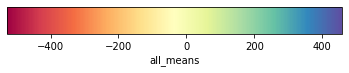

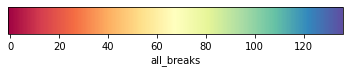

In [17]:
if len(data_list)>1:
    means = big_means_array
    breaks = big_breaks_array
else:
    means = data_list[0].means_array
    breaks = data_list[0].breaks_array

save_plot(means,output_dir, save_name = "all_means")
save_plot(breaks,output_dir, save_name = "all_breaks")

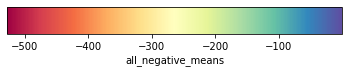

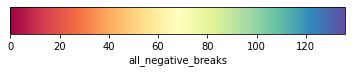

In [18]:
# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = np.nan
means[means > 0] = np.nan # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

save_plot(means, output_dir, save_name = "all_negative_means")
save_plot(breaks_plot, output_dir, save_name = "all_negative_breaks")


In [19]:
dates_monitor = []
dates = data_list[0].cropped_dates

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period

dates_array

array([datetime.datetime(2018, 9, 18, 0, 0),
       datetime.datetime(2018, 9, 19, 0, 0),
       datetime.datetime(2018, 9, 26, 0, 0),
       datetime.datetime(2018, 9, 27, 0, 0),
       datetime.datetime(2018, 10, 4, 0, 0),
       datetime.datetime(2018, 10, 5, 0, 0),
       datetime.datetime(2018, 10, 12, 0, 0),
       datetime.datetime(2018, 10, 13, 0, 0),
       datetime.datetime(2018, 10, 20, 0, 0),
       datetime.datetime(2018, 10, 21, 0, 0),
       datetime.datetime(2018, 10, 28, 0, 0),
       datetime.datetime(2018, 10, 29, 0, 0),
       datetime.datetime(2018, 11, 5, 0, 0),
       datetime.datetime(2018, 11, 6, 0, 0),
       datetime.datetime(2018, 11, 13, 0, 0),
       datetime.datetime(2018, 11, 14, 0, 0),
       datetime.datetime(2018, 11, 21, 0, 0),
       datetime.datetime(2018, 11, 22, 0, 0),
       datetime.datetime(2018, 11, 30, 0, 0),
       datetime.datetime(2018, 12, 7, 0, 0),
       datetime.datetime(2018, 12, 15, 0, 0),
       datetime.datetime(2018, 12, 23, 0, 0

# Classify output for plotting

{2018: 0, 2019: 23, 2020: 93}
first
mid
last
[[0.00000e+00 1.50900e+04]
 [1.00000e+00 5.85097e+05]
 [2.00000e+00 6.71384e+05]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]
 [        nan 1.00000e+00]]


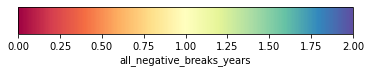

In [20]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
print(idx_starts)

breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        print("last")
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        print("first")
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    print("mid")


save_plot(breaks_plot_years, output_dir, save_name = "all_negative_breaks_years")

#breaks_plot_years = normalize(breaks_plot_years.astype('float'))
#breaks_plot_years = (breaks_plot_years*255)
unique, counts = np.unique(breaks_plot_years, return_counts=True)
print(np.asarray((unique, counts)).T[0:10])

# Plot output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


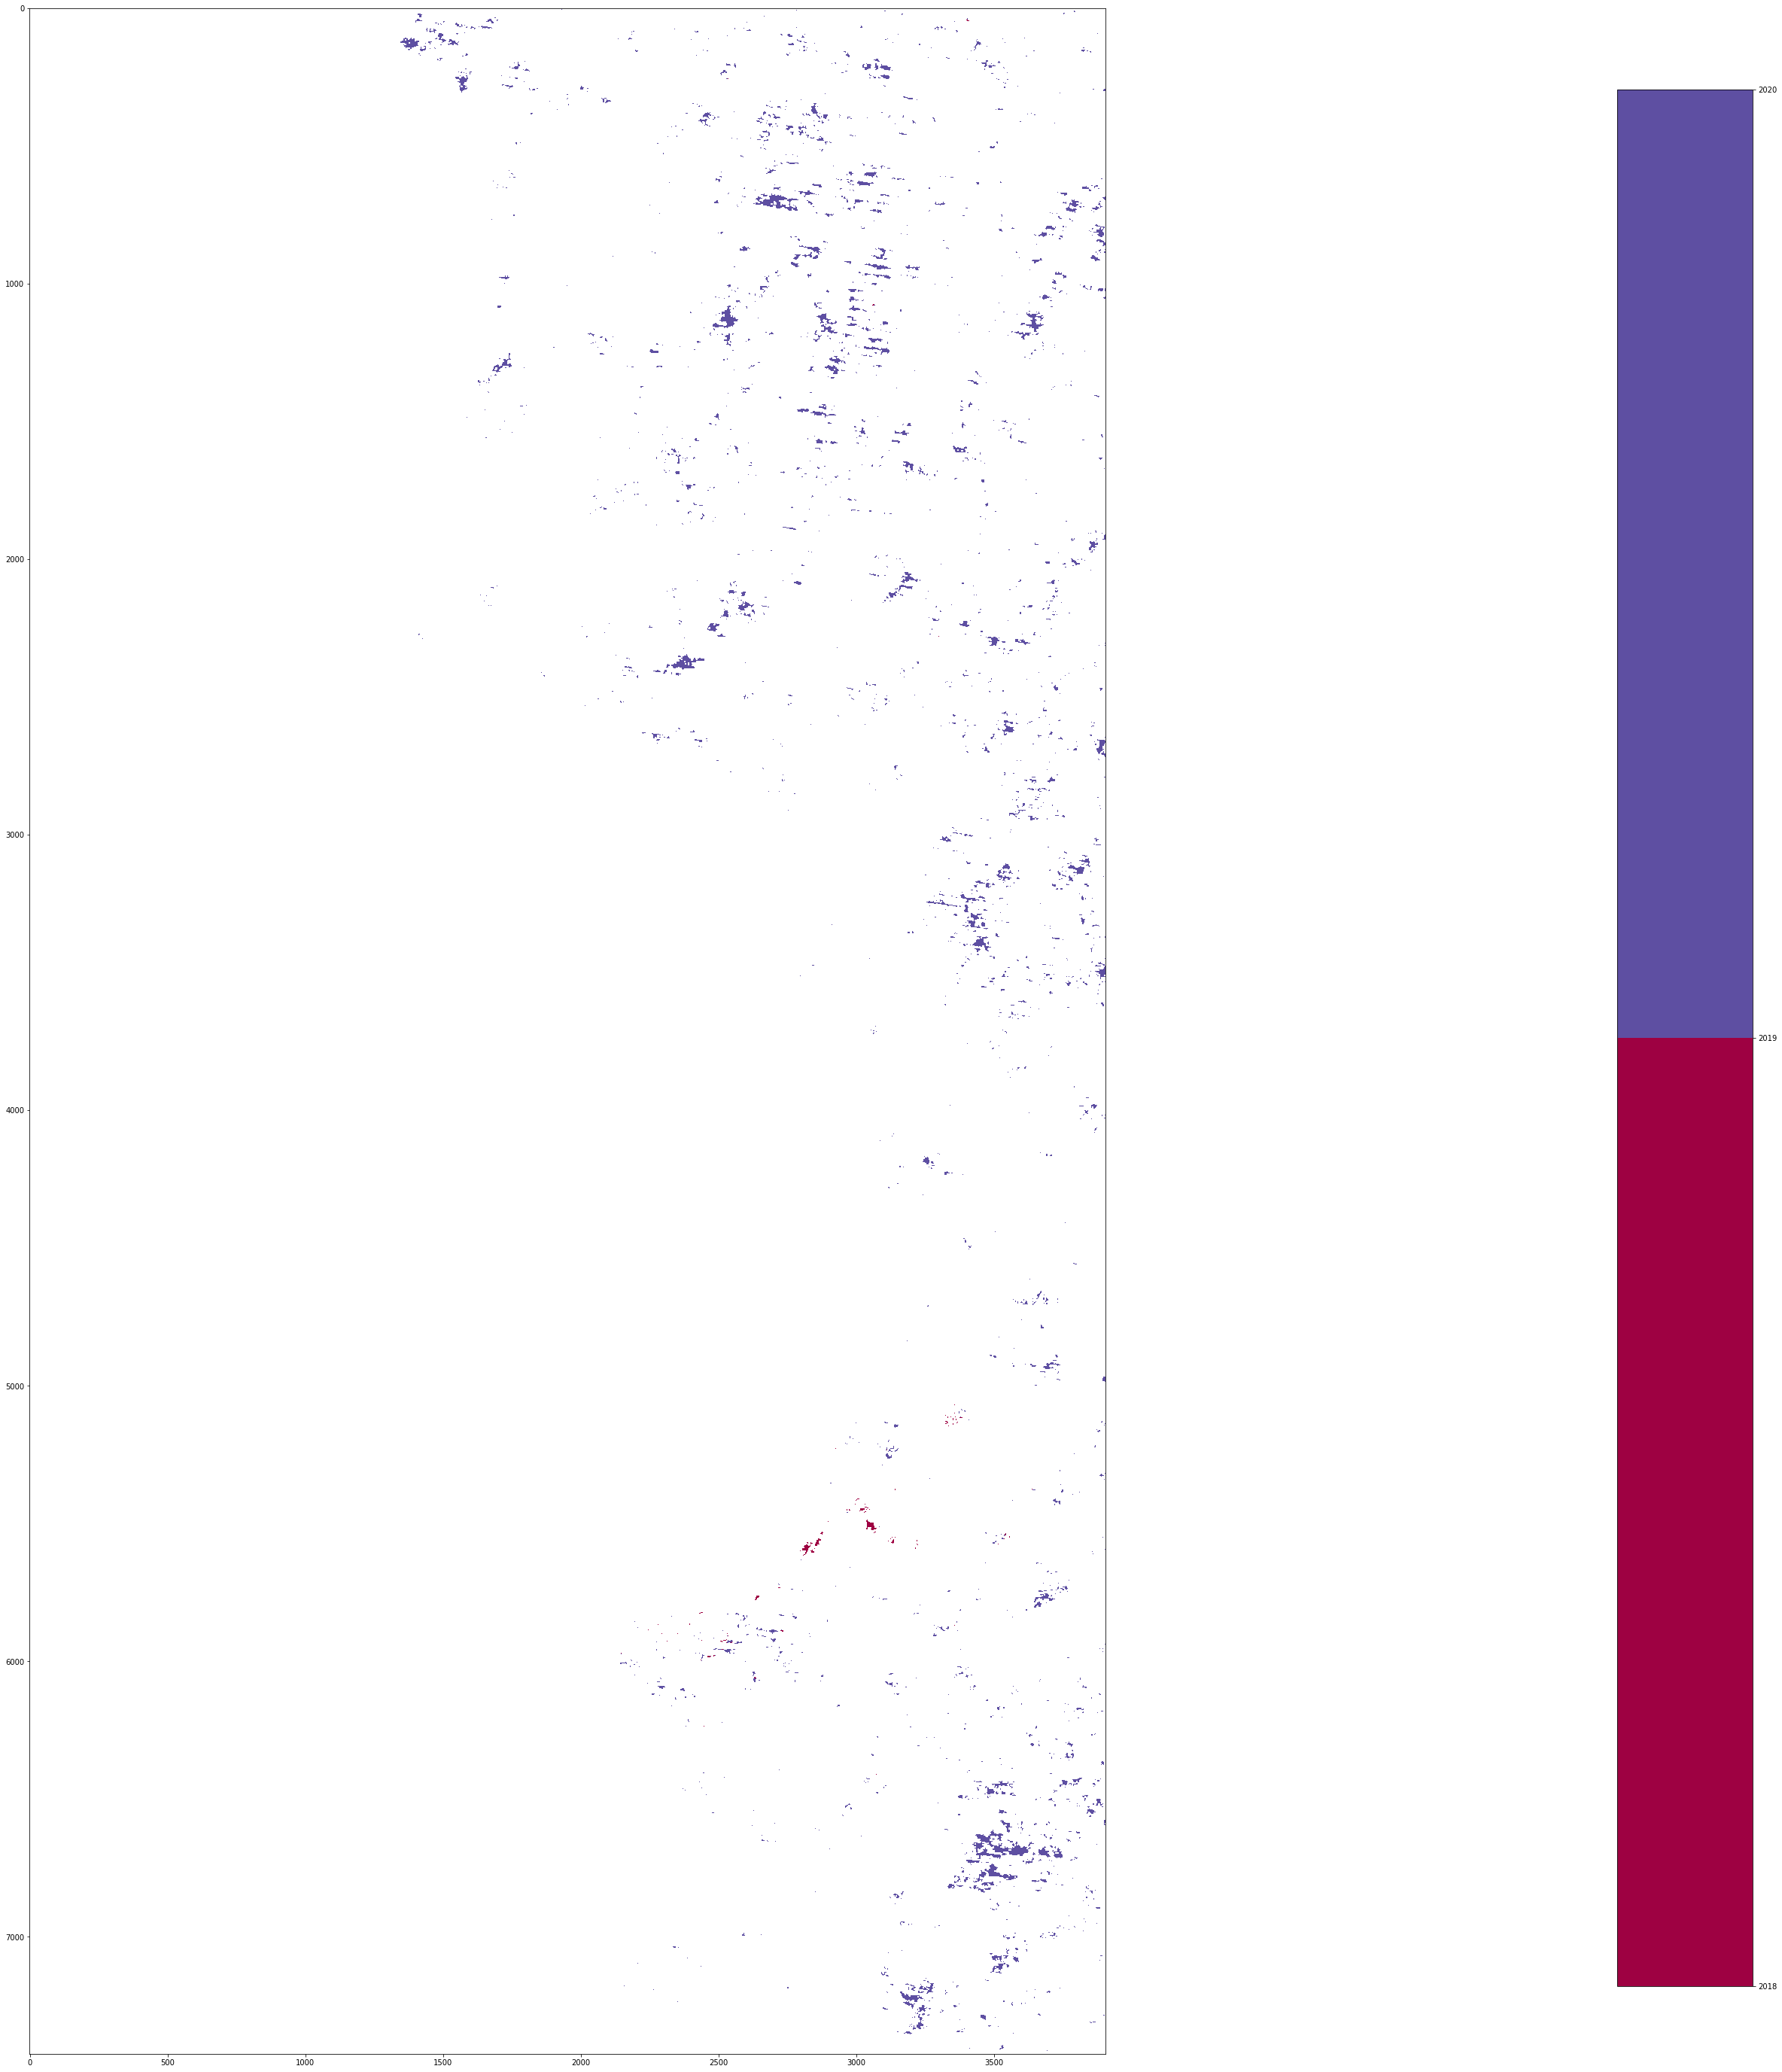

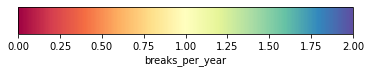

In [21]:
bins = len(idx_starts)

cmap = plt.get_cmap("Spectral")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(50, 50))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.show()

save_plot(breaks_plot_years, output_dir, save_name = "breaks_per_year")

In [22]:
# set corners
min_lat = data_list[0].latitude
max_lat = data_list[0].latitude
min_lon = data_list[0].longitude
max_lon = data_list[0].longitude

for i in range(len(data_list)):
    if data_list[i].latitude > min_lat:
        min_lat = data_list[i].latitude
    if data_list[i].longitude < min_lon:
        min_lon = data_list[i].longitude
        
    if data_list[i].latitude < max_lat:
        max_lat = data_list[i].latitude - data_list[i].nrows*data_list[i].xpixelsize
    if data_list[i].longitude > max_lon:
        max_lon = data_list[i].longitude + data_list[i].ncols*data_list[i].xpixelsize

print("min_lat " , min_lat)
print("max_lat " , max_lat)
print("min_lon " , min_lon)
print("max_lon " , max_lon)
corner_dict = {"min_lat": min_lat,"max_lat": max_lat,"min_lon": min_lon,"max_lon": max_lon}


with open(output_dir + "/" + "corners.json","w") as f:
    json.dump(corner_dict, f)

min_lat  5.17779946613651
max_lat  3.176802170760274
min_lon  -60.4392811362603
max_lon  -59.386635286329046


## Plot all of your segments and save as a html map

In [23]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', index=2, layout=Layout(height='auto', width='500px'…

In [ ]:
from folium.plugins import FloatImage
import base64

import json
# have the user choose a type of output plot with a widget 
#plot_name = "all_negative_means.png"


m = merge_plots(base_output_dir=base_output_dir,plot_name=plot_display_data_chooser.result + ".png")

#m = merge_plots(base_output_dir=base_output_dir,plot_name="breaks_per_year.png")


####
# resolution, width, height = 75, 4,4
# encoded = base64.b64encode(open("output/testcolorbar.png", 'rb').read()).decode()
# from folium import IFrame

# html = '<img src="data:image/png;base64,{}">'.format
# iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
# popup = folium.Popup(iframe, max_width=2650)

# icon = folium.Icon(color="red", icon="ok")
# marker = folium.Marker([data_list[0].latitude, data_list[0].longitude], popup=popup, icon=icon)
# marker.add_to(m)
####


#m.save('output/' + output_directory_chooser.result + "_" + plot_display_data_chooser.result + ".html")
m

In [ ]:
# from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker
# from ipyleaflet import Map, LayersControl, ImageOverlay

# m = Map(center=(max_lat, min_lon), zoom=8)
# url = "stored_time_series/Guyana/image.png"

# image = ImageOverlay(url = url,
#                      bounds=((min_lat, min_lon), (max_lat, max_lon)))

# m.add_layer(Marker(location=(max_lat, min_lon)))

# control = LayersControl(position='topright')
# m.add_control(control)
# m.add_layer(image);

# m

# #m.save('my_map.html', title='My Map')